In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
from engine import *
from nn import *
from extension import *

import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
def bptt_loss(yb_seq, predictions_seq):
    seq_len = len(yb_seq)
    losses = []

    # Compute the loss for each step in the sequence
    for t in range(seq_len):
        yb_t = yb_seq[t]
        predictions_t = predictions_seq[t]  # Extract the Value
        loss_t = (yb_t - predictions_t)**2
        losses.append(loss_t)

    # Average the losses over the sequence length
    total_loss = sum(losses) * (1.0 / seq_len)
    return total_loss

def bptt_mean_relative_error(yb_seq, predictions_seq):
    seq_len = len(yb_seq)
    errors = []

    # Compute the relative error for each step in the sequence
    for t in range(seq_len):
        yb_t = yb_seq[t]
        predictions_t = predictions_seq[t]  # Extract the Value from the tuple
        error_t = abs(yb_t.data - predictions_t.data) / abs(yb_t.data)
        errors.append(error_t)

    # Compute the mean relative error over the sequence length
    mean_relative_error = sum(errors) / seq_len
    return mean_relative_error

def plot_loss_and_accuracy(steps, losses, accuracies, ignore_first_n=0):
    sns.set(style="ticks", context="paper")
    
    # Slice the lists to ignore the first n steps
    steps = steps[ignore_first_n:]
    losses = losses[ignore_first_n:]
    accuracies = accuracies[ignore_first_n:]

    fig, ax1 = plt.subplots()

    # Plot the loss on the left y-axis
    sns.lineplot(x=steps, y=losses, ax=ax1, label="Loss", color="blue", linewidth=1)
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Loss", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # Create a second y-axis for the accuracy
    ax2 = ax1.twinx()

    # Plot the accuracy on the right y-axis
    sns.lineplot(x=steps, y=accuracies, ax=ax2, label="Accuracy", color="red", linewidth=1)
    ax2.set_ylabel("Accuracy", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    # Remove the top and right spines
    sns.despine(ax=ax1, right=True, top=True)
    sns.despine(ax=ax2, left=True, top=True)

    # Show the plot
    plt.title("Loss and Accuracy Evolution")
    plt.show()

Step 499 - Loss: 94.28006272824175, Accuracy: 0.9355274983084028


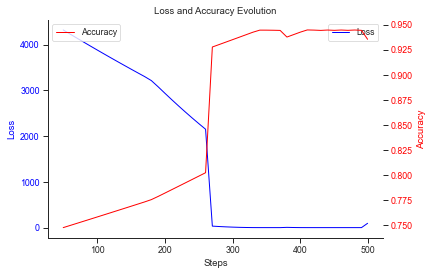

In [156]:
# Create a single-layer RNN with 1 input and 1 output
rnn = RNN(1, [1])
# rnn = RNN(1, [1, 1])

# Data sequence: [0, 1, 2, 3, 4, ...]
input_sequence = [[Value(i)] for i in range(0, 500, 5)]
target_sequence = [[Value(i)] for i in range(5, 505, 5)]

# Initialize hidden state
h_prev_1 = [Value(0)]
# h_prev_2 = [Value(0)]

# optimization
iters = 500
clipping_gradient_at = 1.0
learning_rate_init = 0.1
learning_rate_decay = 0.09
learning_rate_decay_steps = iters

steps, losses, accuracies = [], [], []

# Initialize hidden state for testing
h_prev_test_1 = [Value(97)]
# h_prev_test_2 = [Value(100)]

# Prepare a test input sequence
test_input_sequence = [[Value(i)] for i in range(505, 550, 5)]
test_output_sequence = [[Value(i)] for i in range(510, 555, 5)]

for k in range(iters):

    # forward
    output, h_new = rnn(input_sequence, [h_prev_1])
    # output, h_new = rnn(input_sequence, [h_prev_1, h_prev_2])

    # compute loss
    total_loss = bptt_loss([item for sublist in target_sequence for item in sublist], [item for sublist in output for item in sublist])
    
    # compute accuracy
    test_output, _ = rnn(test_input_sequence, [h_prev_test_1])
    total_accuracy = 1 - bptt_mean_relative_error([item for sublist in test_output_sequence for item in sublist], [item for sublist in test_output for item in sublist])

    # backward 
    rnn.zero_grad()
    total_loss.backward()

    # gradient clipping
    clip_value = clipping_gradient_at
    for p in rnn.parameters():
        grad_norm = p.grad ** 2
        if grad_norm > clip_value ** 2:
            p.grad *= (clip_value / math.sqrt(grad_norm))
    
    # learning rate
    learning_rate = learning_rate_init - learning_rate_decay*k/learning_rate_decay_steps
    for p in rnn.parameters():
        p.data -= learning_rate * p.grad
    
    # store data every 10 steps
    if k % 10 == 0:
        steps.append(k)
        losses.append(total_loss.data)
        accuracies.append(total_accuracy)

steps.append(k)
losses.append(total_loss.data)
accuracies.append(total_accuracy)

print(f"Step {k} - Loss: {total_loss.data}, Accuracy: {total_accuracy}")
plot_loss_and_accuracy(steps, losses, accuracies,ignore_first_n=5)

In [157]:
# Initialize hidden state for testing
h_prev_test_1 = [Value(495)]
# h_prev_test_2 = [Value(100)]

# Prepare a test input sequence
test_input_sequence = [[Value(i)] for i in range(500, 550, 5)]


# Pass the test input sequence and initial hidden state to the RNN
test_output, _ = rnn(test_input_sequence, [h_prev_test_1])

# Print the input test sequence and the corresponding predictions
print("Test input sequence:", [value[0].data for value in test_input_sequence])
print("Test output:", [value[0].data for value in test_output])

Test input sequence: [500, 505, 510, 515, 520, 525, 530, 535, 540, 545]
Test output: [503.2509336924411, 509.51006217819355, 514.9994814234054, 520.1914557613625, 525.2684860812514, 530.3010976635275, 535.3165441572302, 540.3253574082615, 545.3316073221948, 550.3368666652407]
